# LSN Exercise 07.2 - Molecular Dynamics Analysis

## Lennard-Jones Liquid Simulations: MC NVT vs MD NVE

**Analysis of:**
- Potential energy per particle U/N
- Autocorrelation functions
- Statistical uncertainties vs block size

**Simulation conditions:**
- Liquid phase: ρ* = 0.8, T* = 1.1
- Cut-off radius: r*_c = 2.5
- N = 108 particles
- Production runs: 500,000 steps (500 blocks × 1000 steps) [entrambe le simulazioni si sono interrotte prima di completare i 500 blocchi]


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns
import os

# Configurazione plot
plt.rcParams.update({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'figure.dpi': 100,
    'savefig.dpi': 150,
    'font.family': 'serif',
    'axes.grid': True,
    'grid.alpha': 0.3
})


## Data Loading and Preprocessing

In [6]:
def load_simulation_data(simulation_type):
    """Load data from MD or MC simulation results - simplified version"""
    base_path = f"RESULTS/{simulation_type}_production_new/"

    try:
        data_dict = {}

        # Load potential energy (instantaneous values)
        pe_file = f"{base_path}potential_energy.dat"
        if os.path.exists(pe_file):
            with open(pe_file, 'r') as f:
                lines = f.readlines()

            pe_values = []
            for line in lines[1:]:  # Skip header
                line = line.strip()
                if line and not line.startswith('#'):
                    try:
                        pe_values.append(float(line))
                    except ValueError:
                        continue

            data_dict['potential_energy_instantaneous'] = np.array(pe_values)
            print(f"  Loaded {len(pe_values)} instantaneous U/N values")

        # Load g(r) 
        gofr_file = f"{base_path}gofr.dat"
        if os.path.exists(gofr_file):
            try:
                gofr_data = np.loadtxt(gofr_file, comments='#')
                data_dict['gofr'] = gofr_data
                print(f"  Loaded g(r) data: {gofr_data.shape}")
            except Exception as e:
                print(f"  Error loading g(r): {e}")

        return data_dict

    except Exception as e:
        print(f"Error loading {simulation_type} data: {e}")
        return None

# Load data from both simulations
print("Loading simulation data...")
md_data = load_simulation_data("MD")
mc_data = load_simulation_data("MC")

if md_data and mc_data:
    print("\n✓ MD and MC data loaded successfully")
else:
    print("⚠ Error loading simulation data.")

Loading simulation data...
  Loaded 225186 instantaneous U/N values
  Loaded g(r) data: (22500, 3)
  Loaded 302493 instantaneous U/N values
  Loaded g(r) data: (30200, 3)

✓ MD and MC data loaded successfully


## Autocorrelation Analysis

> *"Compute autocorrelation functions of U/N to approximately estimate how large the blocks in your simulations should be."*

MD data: 225186 instantaneous U/N values
MC data: 302493 instantaneous U/N values


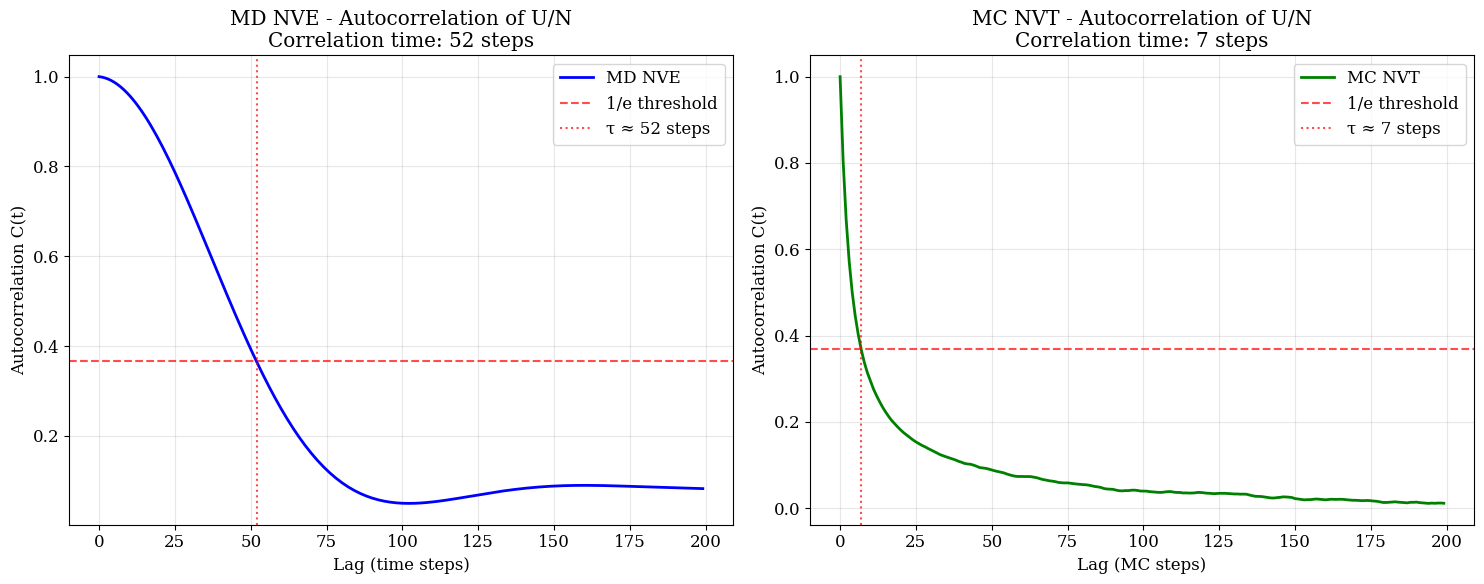

Autocorrelation Analysis Results:
  MD correlation time: 52 steps
  MC correlation time: 7 steps


In [8]:
def autocorrelation_function(data, max_lag=100):
    """Calculate autocorrelation function of time series data"""
    n = len(data)
    data = data - np.mean(data)  # Center the data
    
    autocorr = np.correlate(data, data, mode='full')
    autocorr = autocorr[autocorr.size // 2:]
    autocorr = autocorr / autocorr[0]  # Normalize
    
    return autocorr[:max_lag]

def estimate_correlation_time(autocorr, threshold=1/np.e):
    """Estimate correlation time where autocorr drops to 1/e"""
    try:
        tau_idx = np.where(autocorr <= threshold)[0][0]
        return tau_idx
    except IndexError:
        return len(autocorr)  # If never drops below threshold

if md_data and mc_data and 'potential_energy_instantaneous' in md_data and 'potential_energy_instantaneous' in mc_data:
    # Extract instantaneous U/N values
    md_u_instantaneous = md_data['potential_energy_instantaneous']
    mc_u_instantaneous = mc_data['potential_energy_instantaneous']
    
    print(f"MD data: {len(md_u_instantaneous)} instantaneous U/N values")
    print(f"MC data: {len(mc_u_instantaneous)} instantaneous U/N values")
    
    # Calculate autocorrelation functions
    max_lag = min(200, len(md_u_instantaneous)//4, len(mc_u_instantaneous)//4)
    
    md_autocorr = autocorrelation_function(md_u_instantaneous, max_lag)
    mc_autocorr = autocorrelation_function(mc_u_instantaneous, max_lag)
    
    # Estimate correlation times
    md_tau = estimate_correlation_time(md_autocorr)
    mc_tau = estimate_correlation_time(mc_autocorr)
    
    # Plot autocorrelation functions
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    lags = np.arange(len(md_autocorr))
    
    # MD autocorrelation
    ax1.plot(lags, md_autocorr, 'b-', linewidth=2, label='MD NVE')
    ax1.axhline(y=1/np.e, color='red', linestyle='--', alpha=0.7, label='1/e threshold')
    ax1.axvline(x=md_tau, color='red', linestyle=':', alpha=0.7, label=f'τ ≈ {md_tau} steps')
    ax1.set_xlabel('Lag (time steps)')
    ax1.set_ylabel('Autocorrelation C(t)')
    ax1.set_title(f'MD NVE - Autocorrelation of U/N\nCorrelation time: {md_tau} steps')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # MC autocorrelation
    ax2.plot(lags[:len(mc_autocorr)], mc_autocorr, 'g-', linewidth=2, label='MC NVT')
    ax2.axhline(y=1/np.e, color='red', linestyle='--', alpha=0.7, label='1/e threshold')
    ax2.axvline(x=mc_tau, color='red', linestyle=':', alpha=0.7, label=f'τ ≈ {mc_tau} steps')
    ax2.set_xlabel('Lag (MC steps)')
    ax2.set_ylabel('Autocorrelation C(t)')
    ax2.set_title(f'MC NVT - Autocorrelation of U/N\nCorrelation time: {mc_tau} steps')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Autocorrelation Analysis Results:")
    print(f"  MD correlation time: {md_tau} steps")
    print(f"  MC correlation time: {mc_tau} steps")


## Block Analysis: Statistical Uncertainties vs Block Size

> *"Study the estimation of statistical uncertainties for different block sizes from L=M/N=10 to L=5×10³"*

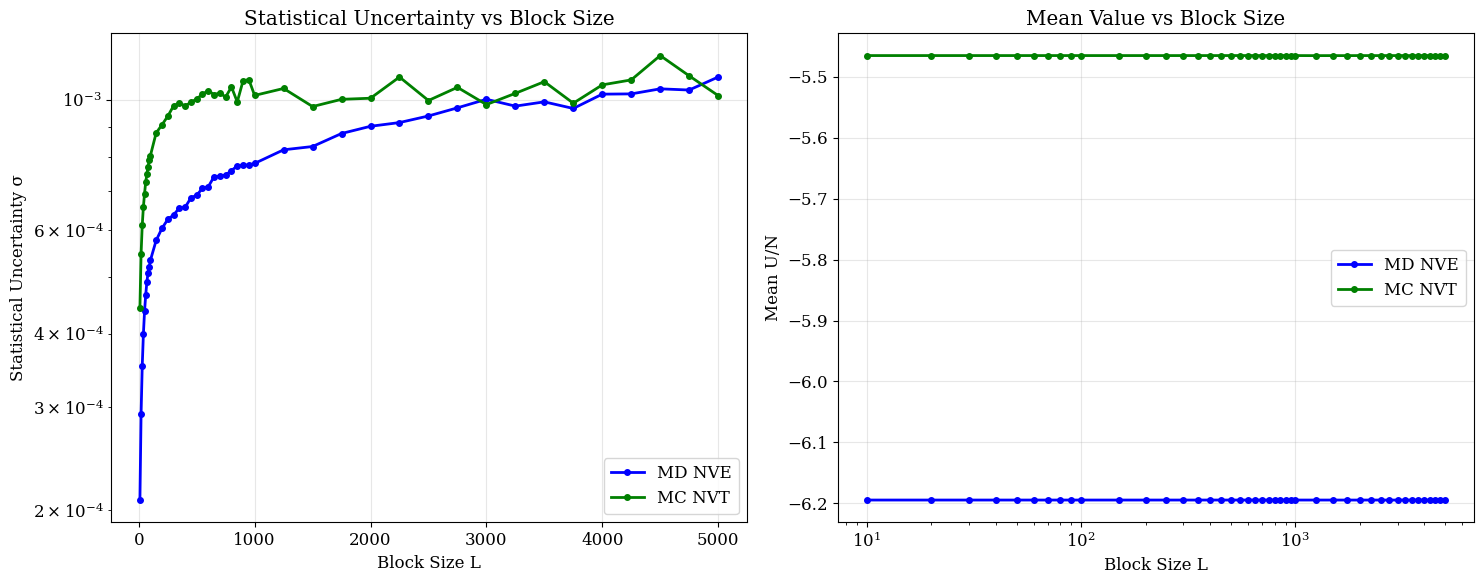

Block Analysis Results:
  MD optimal block size: 50 steps
  MC optimal block size: 30 steps
  Final MD uncertainty: 0.001094
  Final MC uncertainty: 0.001017
  Final MD mean U/N: -6.194544 ± 0.001094
  Final MC mean U/N: -5.465162 ± 0.001017


In [10]:
def block_analysis(data, min_block_size=10, max_block_size=5000):
    """Perform block analysis to study statistical uncertainties vs block size"""
    total_data_points = len(data)
    
    # Generate range of block sizes (L values)
    block_sizes = []
    current = min_block_size
    while current <= min(max_block_size, total_data_points // 2):
        block_sizes.append(current)
        if current < 100:
            current += 10
        elif current < 1000:
            current += 50
        else:
            current += 250
    
    uncertainties = []
    num_blocks_list = []
    means = []
    
    for L in block_sizes:
        # Number of complete blocks
        N = total_data_points // L
        if N < 2:  # Need at least 2 blocks for error estimate
            continue
            
        # Reshape data into blocks and calculate block averages
        truncated_data = data[:N*L]
        blocks = truncated_data.reshape(N, L)
        block_averages = np.mean(blocks, axis=1)
        
        # Calculate overall mean and uncertainty
        overall_mean = np.mean(block_averages)
        block_variance = np.var(block_averages, ddof=1)  # Sample variance
        uncertainty = np.sqrt(block_variance / N)  # Standard error of the mean
        
        uncertainties.append(uncertainty)
        num_blocks_list.append(N)
        means.append(overall_mean)
    
    return np.array(block_sizes[:len(uncertainties)]), np.array(uncertainties), np.array(num_blocks_list), np.array(means)

if md_data and mc_data and 'potential_energy_instantaneous' in md_data and 'potential_energy_instantaneous' in mc_data:
    # Perform block analysis on U/N
    md_u_instantaneous = md_data['potential_energy_instantaneous']
    mc_u_instantaneous = mc_data['potential_energy_instantaneous']
    
    md_block_sizes, md_uncertainties, md_num_blocks, md_means = block_analysis(md_u_instantaneous)
    mc_block_sizes, mc_uncertainties, mc_num_blocks, mc_means = block_analysis(mc_u_instantaneous)
    
    # Plot only the two requested graphs
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Uncertainty vs Block Size
    ax1.semilogy(md_block_sizes, md_uncertainties, 'bo-', linewidth=2, markersize=4, label='MD NVE')
    ax1.semilogy(mc_block_sizes, mc_uncertainties, 'go-', linewidth=2, markersize=4, label='MC NVT')
    ax1.set_xlabel('Block Size L')
    ax1.set_ylabel('Statistical Uncertainty σ')
    ax1.set_title('Statistical Uncertainty vs Block Size')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Mean value vs Block Size (should be constant)
    ax3.semilogx(md_block_sizes, md_means, 'bo-', linewidth=2, markersize=4, label='MD NVE')
    ax3.semilogx(mc_block_sizes, mc_means, 'go-', linewidth=2, markersize=4, label='MC NVT')
    ax3.set_xlabel('Block Size L')
    ax3.set_ylabel('Mean U/N')
    ax3.set_title('Mean Value vs Block Size')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal block size (where uncertainty plateaus)
    def find_plateau_start(block_sizes, uncertainties, window=5):
        """Find where uncertainty starts to plateau"""
        if len(uncertainties) < window:
            return 0
        
        # Calculate relative changes
        rel_changes = np.abs(np.diff(uncertainties) / uncertainties[:-1])
        
        # Find where changes become small
        for i in range(len(rel_changes) - window):
            if np.mean(rel_changes[i:i+window]) < 0.05:  # Less than 5% change
                return i
        return len(rel_changes) // 2
    
    if len(md_uncertainties) > 0 and len(mc_uncertainties) > 0:
        md_plateau_idx = find_plateau_start(md_block_sizes, md_uncertainties)
        mc_plateau_idx = find_plateau_start(mc_block_sizes, mc_uncertainties)
        
        print(f"Block Analysis Results:")
        print(f"  MD optimal block size: {md_block_sizes[md_plateau_idx]:.0f} steps")
        print(f"  MC optimal block size: {mc_block_sizes[mc_plateau_idx]:.0f} steps")
        print(f"  Final MD uncertainty: {md_uncertainties[-1]:.6f}")
        print(f"  Final MC uncertainty: {mc_uncertainties[-1]:.6f}")
        print(f"  Final MD mean U/N: {md_means[-1]:.6f} ± {md_uncertainties[-1]:.6f}")
        print(f"  Final MC mean U/N: {mc_means[-1]:.6f} ± {mc_uncertainties[-1]:.6f}")
    else:
        print("⚠ Insufficient data for block analysis")
else:
    print("⚠ Cannot perform block analysis - instantaneous data not available")

La dimensione ottimale del blocco è quella per cui:

    I blocchi sono sufficientemente grandi da essere statisticamente indipendenti

    L'incertezza ha raggiunto un plateau (non diminuisce più significativamente)

I valori ottimali stampati (MD optimal block size e MC optimal block size) rappresentano il miglior compromesso tra accuratezza statistica e numero di blocchi

Indicano quando l'incertezza smette di cambiare significativamente al crescere di L (Meno del 5% di variazione)